## Overview

This notebook assumes that `generate_all_reconstructions.py` has been run, and the reconstructions are stored in `./outputs/`.

[Test](#flow-distributions)

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import genextreme, pearson3
from scipy.optimize import curve_fit
from scipy.stats import genextreme as gev
from scipy.stats import pearson3
from sklearn.preprocessing import StandardScaler
import spei as si

sys.path.append('../')
from utils.data_processing import extract_realization_from_hdf5
from utils.drought_plots import plot_ssi
from generate_reconstruction import aggregate_node_flows
import geopandas as gpd

# Directory to pywrdrb project
pywrdrb_directory = '../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches, obs_site_matches, immediate_downstream_nodes_dict
from pywrdrb.utils.constants import cms_to_mgd

ModuleNotFoundError: No module named 'utils'

In [2]:
# Load different reconstruction variations
Qhr_catchment_inflows = {}
Qhr_gage_flows = {}
n_realizations= 30

use_old = False
    
for fdc_source in ['nhmv10', 'nwmv21', 
                   'obs_pub_nhmv10_ObsScaled', 'obs_pub_nwmv21_ObsScaled']:
    
    if use_old:
        Qhr_gage_flows[fdc_source]= pd.read_csv(f'./outputs/historic_reconstruction_daily_{fdc_source}_mgd.csv', sep = ',', 
                                                    index_col = 0, parse_dates = True)
    
    else:
        Qhr_catchment_inflows[fdc_source]= pd.read_csv(f'./outputs/catchment_inflow_obs_pub_{fdc_source}.csv', sep = ',', 
                                                    index_col = 0, parse_dates = True)
        Qhr_gage_flows[fdc_source]= pd.read_csv(f'./outputs/gage_flow_obs_pub_{fdc_source}.csv', sep = ',', 
                                                    index_col = 0, parse_dates = True)
    
for fdc_source in ['nhmv10_ObsScaled_ensemble', 'nwmv21_ObsScaled_ensemble']:
    # Load ensemble flows

    catchment_inflow_ensemble_filename= f'./outputs/ensembles/catchment_inflow_obs_pub_{fdc_source}.hdf5'
    gage_flow_ensemble_filename= f'./outputs/ensembles/gage_flow_obs_pub_{fdc_source}.hdf5'
    Qhr_catchment_inflows[fdc_source] = {}
    Qhr_gage_flows[fdc_source] = {}
    
    for i in range(n_realizations):
        Qhr_catchment_inflows[fdc_source][f'realization_{i}']= extract_realization_from_hdf5(catchment_inflow_ensemble_filename, realization=i+1)
        Qhr_gage_flows[fdc_source][f'realization_{i}']= extract_realization_from_hdf5(gage_flow_ensemble_filename, realization=i+1)

# Load historic observations
Q_obs = pd.read_csv('./outputs/streamflow_daily_usgs_1950_2022_cms.csv', sep=',', index_col=0, parse_dates=True)*cms_to_mgd
Q_nhm = pd.read_csv('../Pywr-DRB/input_data/gage_flow_nhmv10.csv', sep=',', index_col=0, parse_dates=True)
Q_nwm = pd.read_csv('../Pywr-DRB/input_data/gage_flow_nwmv21.csv', sep=',', index_col=0, parse_dates=True)

# Other data
unmanaged_meta = pd.read_csv('./data/drb_unmanaged_usgs_metadata.csv')

## Visual overlay

Quick visual of all reconstructions overlaid on one another for nodes of interest.

In [3]:
reconst_colordict = {'nwmv21':{'scaled': 'brown',
                               'unscaled':'tomato',
                               'ensemble':'pink'},
                     'nhmv10':{'scaled':'navy',
                               'unscaled': 'steelblue',
                               'ensemble': 'powderblue'}}

reconst_lsdict = {'scaled': 'dashed',
                  'unscaled':'solid'}

In [4]:

def plot_all_reconstructions(Q_recontruction, Q_obs, plot_node,  
                             t_start, t_end, 
                             plot_ensemble_quantiles=True,
                             title_text=None,
                             plot_type='timeseries'):
    fig, ax= plt.subplots(figsize=(10,4), dpi=200)

    fdc_quantiles= np.linspace(0.00001,0.99999,200)

    consider_datasets=['unscaled', 'scaled'] # if plot_node in ['cannonsville', 'pepacton', 'NYC Total'] else ['unscaled']


    for fdc_source in ['nhmv10_ObsScaled_ensemble', 'nwmv21_ObsScaled_ensemble',
                       'nhmv10_ObsScaled', 'nwmv21_ObsScaled']:
        if plot_node not in ['cannonsville', 'pepacton','NYC Total']:
            if 'ensemble' in fdc_source:
                # Get data from all realizations
                Q_ensemble = Q_recontruction[fdc_source]['realization_0'].loc[t_start:t_end, plot_node]
                for i in range(1, n_realizations): 
                    # Concatenate all realizations
                    single_real = Q_recontruction[fdc_source][f'realization_{i}'].loc[t_start:t_end, plot_node]
                    Q_ensemble = pd.concat([Q_ensemble, single_real], axis=1)

                c = reconst_colordict[fdc_source.split('_')[0]]['ensemble']
                
                # Get upper and lower quantiles
                lower_quantile = Q_ensemble.quantile(0.01, axis=1)
                upper_quantile = Q_ensemble.quantile(0.99, axis=1)
                median = Q_ensemble.median(axis=1)
                
                if plot_type == 'timeseries':
                    if plot_ensemble_quantiles:
                        ax.fill_between(Q_ensemble.index, lower_quantile, upper_quantile, 
                                        color=c, alpha=0.5, 
                                        label= f'{fdc_source.split("_")[0]}-based QPPQ ensemble range')
                        # Plot median
                        # ax.plot(median, color=c, lw=0.75, alpha=1, label= f'{fdc_source} QPPQ ensemble median')
                    else:
                        ax.plot(Q_ensemble, color=c, alpha=0.4) #, label= f'{fdc_source} QPPQ sampled traces')

            else:
                Q_hr= Q_recontruction[fdc_source]
                s = 'scaled' if 'ObsScaled' in fdc_source else 'unscaled'
                c = reconst_colordict[fdc_source.split('_')[0]][s]
                
                if plot_type == 'timeseries':
                    ax.plot(Q_hr.loc[t_start:t_end, plot_node], 
                            color=c, lw=0.75, alpha=1, 
                            label= f'{fdc_source.split("_")[0]}-based aggregate QPPQ')


                        
    # If a obs gauge is included, add that
    if obs_site_matches[plot_node]:
        ax.plot(Q_obs.loc[t_start:t_end, [f'USGS-{s}' for s in obs_site_matches[plot_node]]].sum(axis=1),
                color = 'black', lw=0.7, ls ='dashed', 
               label = 'Observed Gauge Flow', zorder=5)
            
        
    # ax.set_xlabel('Date')
    # ax.set_ylabel('Flow (MGD)')
    ax.set_yscale('log')
    h, l = ax.get_legend_handles_labels()
    legend= ax.legend(h,l,loc='lower center', bbox_to_anchor=(0.5, -0.65), ncol=2)
    if title_text:
        plt.title(title_text)
    # plt.ylim([1, 100000])
    # plt.tight_layout()
    # plt.axis('off')
    # plt.savefig(f'./figures/hist_reconst_all_{plot_node}.png', dpi=200)
    return


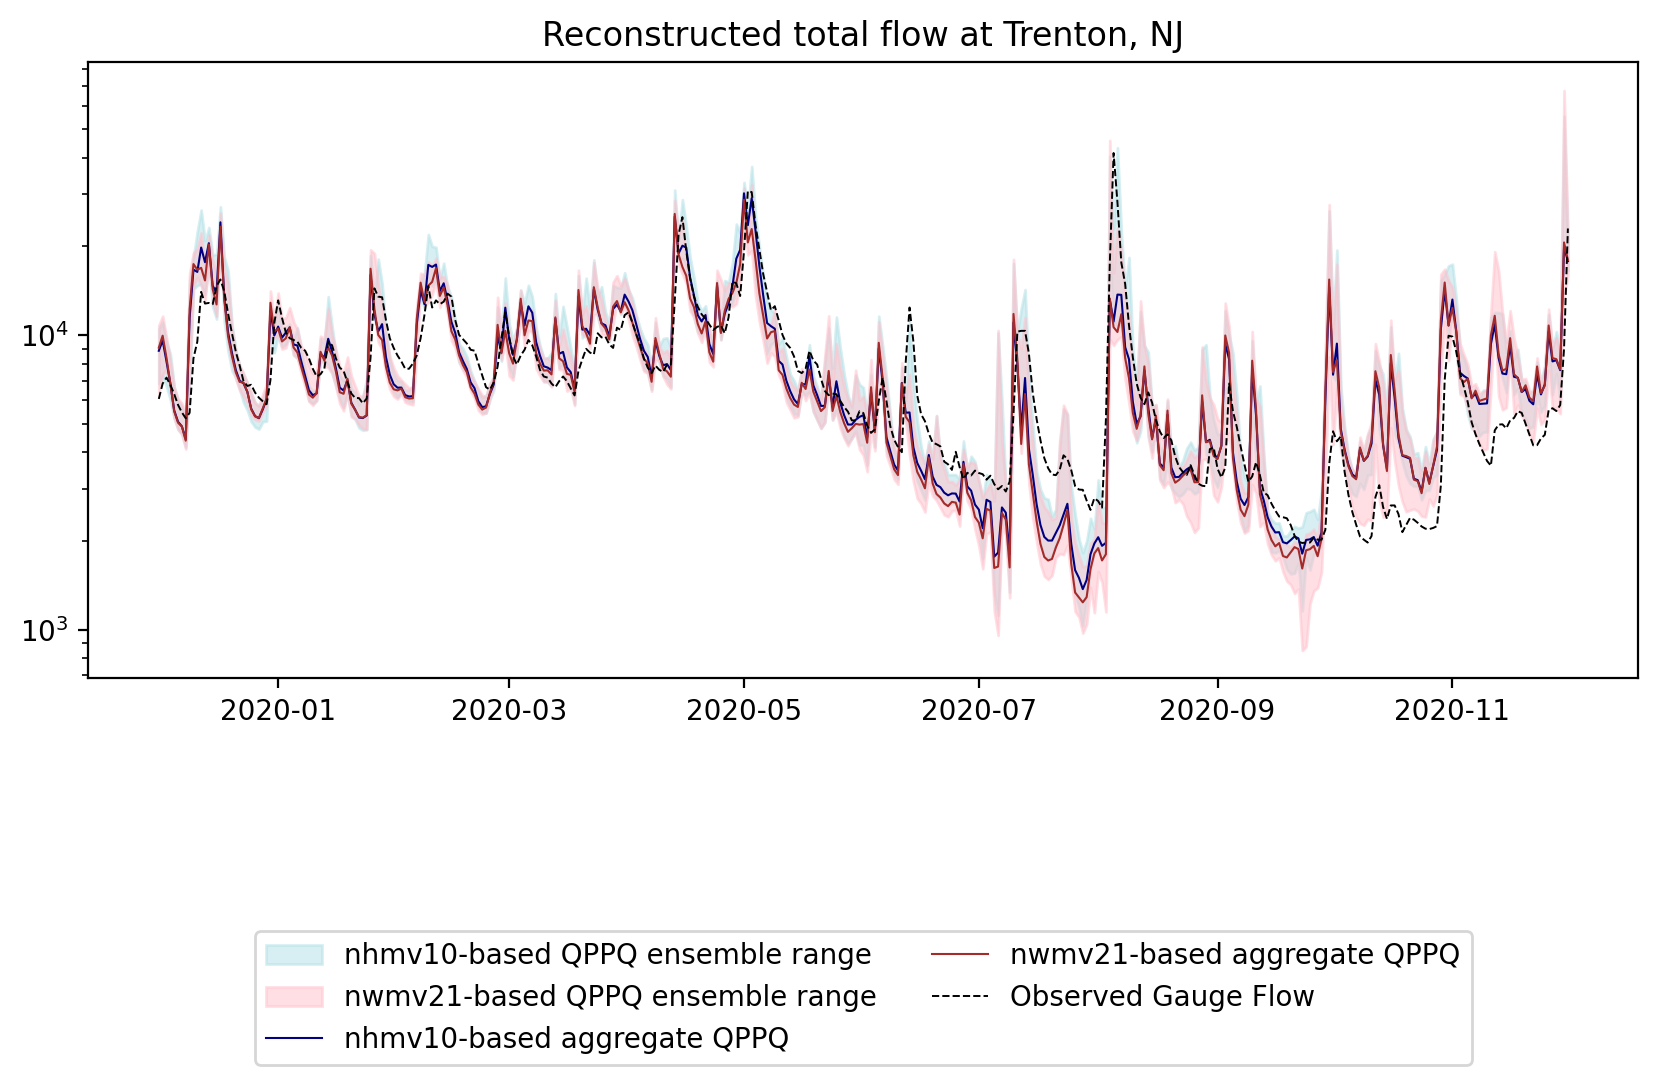

In [6]:
plot_node= 'delDRCanal'
t_start='2019-12-01'
t_end='2020-12-01'

plot_all_reconstructions(Qhr_gage_flows, Q_obs, plot_node,plot_ensemble_quantiles=True, 
                         title_text='Reconstructed total flow at Trenton, NJ',
                         t_start=t_start, t_end=t_end)

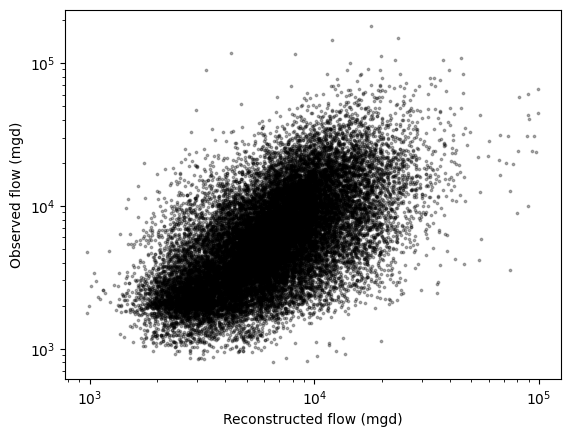

In [6]:
plt.scatter(Qhr_gage_flows['nhmv10_ObsScaled'].loc['1950-01-01':, 'delDRCanal'],
            Q_obs[[f'USGS-{s}' for s in obs_site_matches[plot_node]]], 
            s=3, c = 'black', alpha=0.3)
plt.xlabel('Reconstructed flow (mgd)')
plt.ylabel('Observed flow (mgd)') 
plt.yscale('log')
plt.xscale('log')
plt.show()

In [13]:
Qhr_catchment_inflows

{'nhmv10_NYCScaled_ensemble': {'realization_0':             cannonsville     pepacton   neversink  wallenpaupack    prompton   
  1945-01-01   2374.152436  2660.371774  348.942837    1203.558048  250.277719  \
  1945-01-02   2509.034251  2671.333198  379.313788     959.136860  159.277262   
  1945-01-03   1554.034307  1628.542714  193.857132     556.977115  100.805709   
  1945-01-04   1226.648214  1298.321459  168.009514     435.054312   72.373329   
  1945-01-05    847.280094   992.742578  148.623801     307.654928   57.510949   
  ...                  ...          ...         ...            ...         ...   
  2022-12-27    929.915178   825.479568  166.717133     461.609060   67.203806   
  2022-12-28    808.914254   722.015152  149.916182     411.816824   62.228139   
  2022-12-29    717.970732   645.944850  136.992373     381.976977   53.181473   
  2022-12-30    728.677564   699.040229  148.623801     385.386392   65.265234   
  2022-12-31    944.929634   960.037557  205.488560 